# Philadelphia Police Department - Vehicle & Pedestrians Investigations
**RACISM EXISTS.**

**WE SEE IN THE VIDEOS.**

**WE HEAR ABOUT IT THROUGH OTHERS.**

**IN MANY CASES, WE EXPERIENCE IT OURSELVES.**

---

Blacks take up a disproportionate share of the police investigation reports.

The City of Philadelphia provides public data about many departments in the city. Lets review the Vehicle & Pedestrians Investigations reported by Philadelphia Police Department.

I aggregated the data using Python programming language.

Please feel free to visit the Instagram post that used this data
https://www.instagram.com/p/CBwAHLjBISA/?igsh=MTZuemo5a3dzM3o2aw%3D%3D&img_index=1


### TODO:
- Update Document to gather data from 2024
- https://phl.carto.com/api/v2/sql?q=SELECT COUNT(*) race FROM car_ped_stops WHERE extract(year from datetimeoccur) = 2024 GROUP BY race LIMIT 10

## Plotting Demographics

Run this to set the variables and import the libraries needed

In [1]:
# import libraries
import numpy as np
import pandas as pd
from pandas import DataFrame
import requests
import json

import matplotlib.pyplot as plt
from matplotlib import rcParams

%matplotlib inline
# %load_ext google.colab.data_table
# %unload_ext google.colab.data_table

base_url = "https://phl.carto.com/api/v2/sql"

# format plot figure size
rcParams['figure.figsize'] = 12,8

def gen_sql_query(i_type, year = None, fd = None, sd = None, ad = None, c = None, v_fd = None, v_sd = None, v_c = None):

  v = ""
  w_arr = []
  if(i_type == ""):
    if(fd != ""):
      w_arr.append("individual_frisked = {}".format(fd))
    if(sd != ""):
      w_arr.append("individual_searched = {}".format(sd))
    if(ad != ""):
      w_arr.append("individual_arrested = {}".format(ad))
    if(c != ""):
      w_arr.append("individual_contraband = {}".format(c))
    if(v_fd != ""):
      w_arr.append("vehicle_frisked = {}".format(v_fd))
    if(v_sd != ""):
      w_arr.append("vehicle_searched = {}".format(v_sd))
    if(v_c != ""):
      w_arr.append("vehicle_contraband = {}".format(v_c))
    for w in w_arr:
      v = "{} AND {}".format(v,w)

  elif(i_type == "pedestrian"):
    w_arr.append("stoptype = 'pedestrian'")
    if(fd != ""):
      w_arr.append("individual_frisked = {}".format(fd))
    if(sd != ""):
      w_arr.append("individual_searched = {}".format(sd))
    if(ad != ""):
      w_arr.append("individual_arrested = {}".format(ad))
    if(c != ""):
      w_arr.append("individual_contraband = {}".format(c))
    for w in w_arr:
      v = "{} AND {}".format(v,w)
  else:
    w_arr.append("stoptype = 'vehicle'")
    if(fd != ""):
      w_arr.append("individual_frisked = {}".format(fd))
    if(sd != ""):
      w_arr.append("individual_searched = {}".format(sd))
    if(ad != ""):
      w_arr.append("individual_arrested = {}".format(ad))
    if(c != ""):
      w_arr.append("individual_contraband = {}".format(c))
    if(v_fd != ""):
      w_arr.append("vehicle_frisked = {}".format(v_fd))
    if(v_sd != ""):
      w_arr.append("vehicle_searched = {}".format(v_sd))
    if(v_c != ""):
      w_arr.append("vehicle_contraband = {}".format(v_c))
    for w in w_arr:
      v = "{} AND {}".format(v,w)

  y = "AND extract(year from datetimeoccur) = {}".format(year) if year != "All" else ""
  print(y)
  combined = "{} {}".format(v,y)

  if(year == "All"):
    q = "{}?q=SELECT COUNT(*), race, extract(year from datetimeoccur) as year FROM car_ped_stops WHERE race NOT LIKE '%25Latino%25' {} GROUP BY race, extract(year from datetimeoccur)  \
    UNION SELECT COUNT(*), 'Black' AS race, extract(year from datetimeoccur) as year FROM car_ped_stops WHERE race LIKE '%25Black%25' {} GROUP BY extract(year from datetimeoccur) \
    UNION SELECT COUNT(*), 'White' AS race, extract(year from datetimeoccur) as year FROM car_ped_stops WHERE race LIKE '%25White%25' {} GROUP BY extract(year from datetimeoccur)".format(
        base_url, combined, combined, combined
    )
  else:
    q = "{}?q=SELECT COUNT(*), race FROM car_ped_stops WHERE race NOT LIKE '%25Latino%25' {} GROUP BY race \
    UNION SELECT COUNT(*), 'Black' AS race FROM car_ped_stops WHERE race LIKE '%25Black%25' {} \
    UNION SELECT COUNT(*), 'White' AS race FROM car_ped_stops WHERE race LIKE '%25White%25' {}".format(
        base_url, combined, combined, combined
    )
  print(q)
  return q

In [ ]:
#@title Fields { run: "auto", vertical-output: true }

import ipywidgets as widgets
from IPython.display import display, clear_output

st_opts = [("Pedestrian","pedestrian"), ("Vehicle","vehicle"), ("Both", "")]
stop_type = widgets.Dropdown(description="Stop Type", options=st_opts)

year_opts = ["All", 2021 ,2020,2019,2018,2017,2016,2015,2014]
year = widgets.Dropdown(description="year", options=year_opts)

opts = [("Yes", 1), ("No", 0), ("Include Both", "")]
fd = widgets.Dropdown(description="Frisked", options=opts)
sd = widgets.Dropdown(description="Searched", options=opts)
ad = widgets.Dropdown(description="Arrested", options=opts)
c = widgets.Dropdown(description="Contraband", options=opts)

v_fd = widgets.Dropdown(description="Vehicle Frisked", options=opts)
v_sd = widgets.Dropdown(description="Vehicle Searched", options=opts)
v_c = widgets.Dropdown(description="Vehicle Contraband", options=opts)

button = widgets.Button(description="Submit Request")

DF = DataFrame()

def on_button_clicked(b):
  global DF
  # Display the message within the output widget.
  url = gen_sql_query(stop_type.value, year.value, fd.value, sd.value, ad.value, c.value, v_fd.value, v_sd.value, v_c.value)

  # make a call to API endpoint and store response
  response = requests.get(url = url).content
  data = json.loads(response)['rows']


  # load data into DataFrame
  DF = DataFrame(data)
  if(year.value == "All"):
    DF = DF.sort_values(['race','year'], ascending=True) # orders the data by count
  else:
    DF = DF.sort_values(['count'], ascending=True) # orders the data by count

  display(DF) # shows data frame (below)

def st_value_change(change):
    if(change['new'] == "pedestrian"):
      v_fd.layout.visibility = "hidden"
      v_sd.layout.visibility = "hidden"
      v_c.layout.visibility = "hidden"
    else:
      v_fd.layout.visibility = "visible"
      v_sd.layout.visibility = "visible"
      v_c.layout.visibility = "visible"
    # with output:
    #     print(change['new'])

# def on_value_change(change):
#     with output:
#         print(change['new'])

stop_type.observe(st_value_change, names="value")
# fd.observe(on_value_change, names="value")
# sd.observe(on_value_change, names="value")
# ad.observe(on_value_change, names="value")
# c.observe(on_value_change, names="value")
button.on_click(on_button_clicked)

output = widgets.Output()
display(stop_type,year, fd, sd, ad, c, v_fd, v_sd, v_c, output, button)
v_fd.layout.visibility = "hidden"
v_sd.layout.visibility = "hidden"
v_c.layout.visibility = "hidden"

# **Race Count of Individuals Investigated (2020)**

In [ ]:
# url = gen_sql_query()
# make a call to API endpoint and store response
# response = requests.get(url = url).content
# data = json.loads(response)['rows']


# load data into DataFrame
# DF = DataFrame(data)
# DF = DF.sort_values('count', ascending=True) # orders the data by count

DF # shows data frame (below)



In [ ]:
# Create the pie chart
colors = plt.cm.Paired(range(len(DF))) # Use a colormap for better aesthetics
wedges, texts, autotexts = plt.pie(x = DF['count'], autopct='%1.1f%%', shadow=False, startangle=0, colors=colors, pctdistance=1.15, wedgeprops={"edgecolor":"none",'linewidth': 0.5, 'linestyle': '-', 'antialiased': True}) # Display percentage

# # it looks better... just need more formatting
plt.legend(wedges, DF['race'], title="Categories", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1), fontsize=12)

for index, text in enumerate(autotexts):
    text.set_fontweight('medium')
    text.set_fontsize(12)
    if text.get_text() == '0.3%':
        (x,y) = text.get_position()
        text.set_position((x+0.1,y))

# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')

# graph needs labels & titles right?
plt.title('Philadelphia Police Car / Pedestrians Stop Demographics', size=18)

# Display the chart
plt.show()

# plt.tight_layout()
# save image
# plt.savefig('car_ped_stops-demographics.png', format='png', bbox_inches = 'tight',
#     pad_inches = 0.05)
# DF.to_csv("car_ped_stops-demographics-3.csv", index=False)


## Investigations grouped by Age and Race

In [3]:
# store API endpoint into variable

age_url = 'https://phl.carto.com/api/v2/sql?q=\
SELECT race, age, COUNT(*) FROM car_ped_stops group by age, race'

# make a call to API endpoint and store response
response = requests.get(url = age_url).content
# print(response)
data = json.loads(response)['rows']
# data

# load data into DataFrame
DF = DataFrame(data)
# DF

# place data into age range.. lowest age 0, highest 119
bin = pd.cut(DF['age'], [-1,12,17,34,64,119], labels=[
    '0-12 years old',
    '12-17 years old',
    '17-34 years old',
    '34-64 years old',
    '64-119 years old',])
AGE_DF = DF[0:]
AGE_DF = AGE_DF.assign(age_range = pd.Series(bin.values))
AGE_DF = AGE_DF.drop('age', axis=1)
AGE_DF

# get rid of Null values (empty values) in DataFrame
AGE_DF['age_range'] = AGE_DF['age_range'].cat.add_categories('Age Unknown')
AGE_DF['age_range'] = AGE_DF['age_range'].fillna('Age Unknown')
# group data by age_range and race
AGE_GROUP_DF = AGE_DF.groupby(['age_range','race'], observed=False).sum()
AGE_GROUP_DF = AGE_GROUP_DF.unstack()

AGE_GROUP_DF


count                                           \
race             American Indian  Asian Black - Latino Black - Non-Latino   
age_range                                                                   
0-12 years old                 8     35             51               3180   
12-17 years old               96    809            891              53598   
17-34 years old             4216  30107          20611            1222556   
34-64 years old             4380  31616          13391             777814   
64-119 years old             262   2550            513              51189   
Age Unknown                   33    168             90               2453   

                                                            
race             Unknown White - Latino White - Non-Latino  
age_range                                                   
0-12 years old        54            273                460  
12-17 years old      669           6591               8269  
17-34 years old    20986         163757             274086  
34-64 years old    14755          99451             232746  
64-119 years old     740           4090              21401  
Age Unknown          112            639               1052

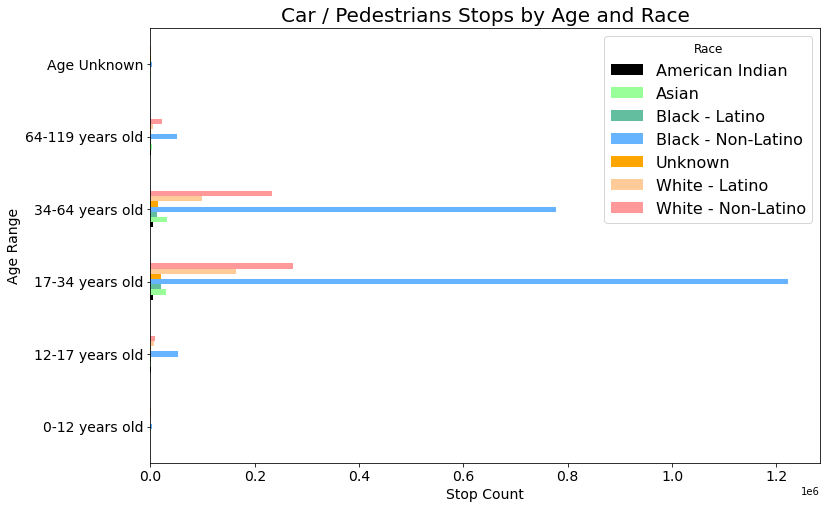

In [6]:
colors = ['black','#99ff99','#63bea0','#66b3ff','orange','#ffcc99','#ff9999']

# plot data
# plot = AGE_GROUP_DF['count'].plot.barh(color=colors, figsize=(10,20)
#                                        ,fontsize=14)
plot = AGE_GROUP_DF['count'].plot.barh(color=colors, fontsize=14)
plot.legend(title='Race', title_fontsize=12,loc=1, prop={'size': 16})

# make Age Unknown show at bottom of y axis
# plt.gca().invert_yaxis() dont need it
plt.title("Car / Pedestrians Stops by Age and Race", size=20)
plt.xlabel('Stop Count', size=14)
plt.ylabel('Age Range', size=14)

# save graph
plt.savefig('stops_by_age_and_race.png', format='png'
           , bbox_inches='tight', pad_inches=0.4)


## Investigations Grouped By Stop Type and Race

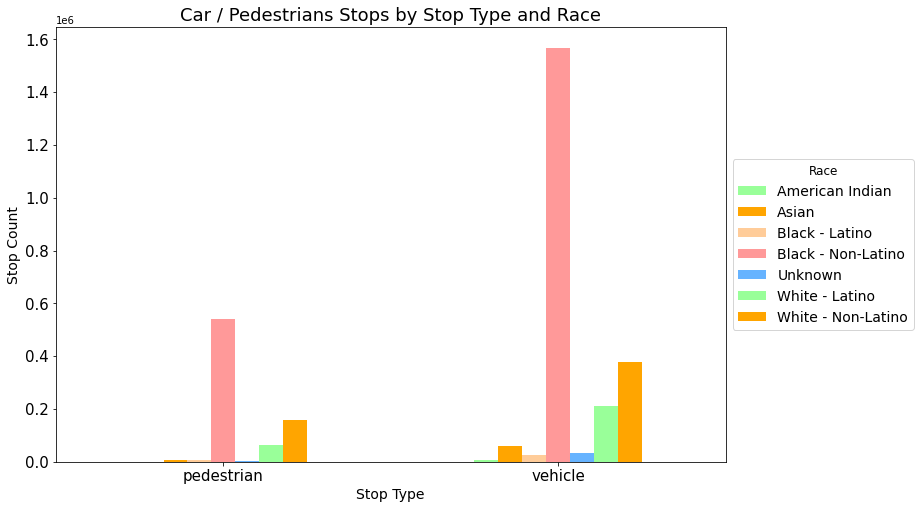

In [7]:
colors = ['#99ff99', 'orange','#ffcc99','#ff9999','#66b3ff']

stop_url = 'https://phl.carto.com/api/v2/sql?q=\
SELECT race, stoptype, COUNT(*) FROM car_ped_stops group by race, stoptype'

# make a call to API endpoint and store response
response = requests.get(url = stop_url).content
# print(response)
data = json.loads(response)['rows']
# data

# load data into DataFrame
STOP_DF = DataFrame(data)
STOP_DF

# group data by stop type and race
STOP_GROUP_DF = STOP_DF.groupby(['stoptype','race']).sum()
STOP_GROUP_DF = STOP_GROUP_DF.unstack()
STOP_GROUP_DF

# plot data
plot = STOP_GROUP_DF['count'].plot(kind='bar',
                                   color = colors,
                                   rot=0,
                                   fontsize=15)
plot.legend(title='Race', title_fontsize=12, loc="center left", prop={'size': 14}, bbox_to_anchor=(1, 0, 0.5, 1))
plot.set_title('Car / Pedestrians Stops by Stop Type and Race', size=18)
plt.xlabel('Stop Type', size=14)
plt.ylabel('Stop Count', size=14)

plt.savefig('stops_by_stoptype_and_race.png', format='png'
           , bbox_inches='tight', pad_inches=0.4)


## Investigations Grouped by Gender & Race

b'{"rows":[{"race":"American Indian","gender":"Female","count":1490},{"race":"American Indian","gender":"Male","count":7502},{"race":"American Indian","gender":null,"count":3},{"race":"Asian","gender":"Female","count":15557},{"race":"Asian","gender":"Male","count":49721},{"race":"Asian","gender":null,"count":7},{"race":"Black - Latino","gender":"Female","count":7065},{"race":"Black - Latino","gender":"Male","count":28473},{"race":"Black - Latino","gender":null,"count":9},{"race":"Black - Non-Latino","gender":"Female","count":543891},{"race":"Black - Non-Latino","gender":"Male","count":1566262},{"race":"Black - Non-Latino","gender":null,"count":637},{"race":"Unknown","gender":"Female","count":7680},{"race":"Unknown","gender":"Male","count":29604},{"race":"Unknown","gender":null,"count":32},{"race":"White - Latino","gender":"Female","count":67469},{"race":"White - Latino","gender":"Male","count":207200},{"race":"White - Latino","gender":null,"count":132},{"race":"White - Non-Latino","gen

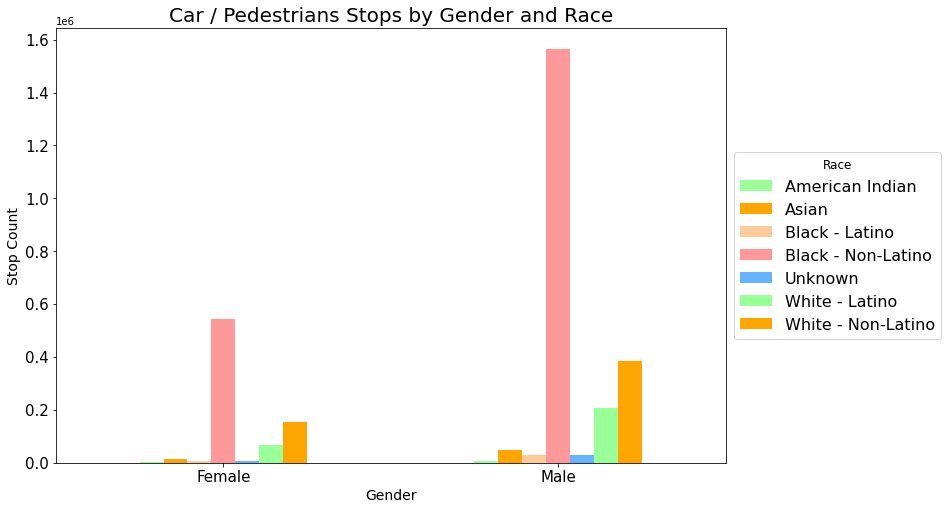

In [8]:
colors = ['#99ff99', 'orange','#ffcc99','#ff9999','#66b3ff']

gender_url = 'https://phl.carto.com/api/v2/sql?q=\
SELECT race, gender, COUNT(*) FROM car_ped_stops group by race, gender'

# make a call to API endpoint and store response
response = requests.get(url = gender_url).content
print(response)
data = json.loads(response)['rows']
# data

# load data into DataFrame
GENDER_DF = DataFrame(data)
GENDER_DF

# group data by stop type and race
GENDER_GROUP_DF = GENDER_DF.groupby(['gender','race']).sum()
GENDER_GROUP_DF = GENDER_GROUP_DF.unstack()
GENDER_GROUP_DF

# plot data
plot = GENDER_GROUP_DF['count'].plot(kind='bar',
                                   color = colors,
                                   rot=0,
                                   fontsize=15)
plot.legend(title='Race', title_fontsize=12, loc="center left", prop={'size': 16}, bbox_to_anchor=(1, 0, 0.5, 1))
plot.set_title('Car / Pedestrians Stops by Gender and Race', size=20)
plt.xlabel('Gender', size=14)
plt.ylabel('Stop Count', size=14)
plt.savefig('stops_by_gender_and_race.png', format='png'
           , bbox_inches='tight', pad_inches=0.4)
